<a href="https://colab.research.google.com/github/Dipak703/stablediffusion_to_replace_object_in_image/blob/main/Image_Generation_and_Background_Replacement_using_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Image Generation and Background Replacement using Stable Diffusion**


In [1]:
# **Introduction**
# This Colab notebook demonstrates the use of Stable Diffusion for image generation and background replacement. The steps include:
# - Setting up the environment and installing necessary libraries.
# - Loading a quantized Stable Diffusion model to generate images.
# - Saving the generated image.
# - Load a deeplabv3_resnet50 model for masking the object or foreground in generated image. #this model works on the boundary segmentation by sharping the edges.
# - Generating the mask for original image.
# - Using stable diffusion inpainting model generate new image with orignial_image, generated_mask, replacing prompt.
# - Replacing the background of the generated images with a custom one.
# - Saving the result and mask

# ** problems faced **
# can't get access to sd3.5 and flux

# **Goals**
# - Familiarize with Stable Diffusion for AI-based image generation.
# - Generate the image using stable diffusion model
# - Auto-generated The mask for object/human replacement
# - save the results


# **Setup: Import Libraries**


In [2]:
# Import necessary libraries for Stable Diffusion and image processing.
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
import cv2
import numpy as np
from urllib.request import urlretrieve
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from torchvision import transforms


Setup the path for storing results

In [3]:
input_file = '/content/generated_image.png'#path for originally image
foreground_file = '/content/foreground.png'#path for original_image_mask image
output_file = '/content/final.jpg'#path for result image



# **Initialize the pipeline for Stable Diffusion image generation.**


In [4]:
# Load the Stable Diffusion Model
def load_model():
    """
    Load the Stable Diffusion model from the Hugging Face library.

    Returns:
        pipeline (StableDiffusionPipeline): Initialized pipeline for image generation.
    """
    model_id = "CompVis/stable-diffusion-v1-4"  # Model ID from Hugging Face
    pipeline1 = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)  # Initialize pipeline
    pipeline1 = pipeline1.to("cuda")  # Move model to GPU for faster processing
    return pipeline1

In [5]:
pipeline1 = load_model() #initilizinge the load_model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# Function to create an image from a text prompt.
def generate_image(prompt, steps=50):
    """
    Generate an image based on a given text prompt.

    Args:
        prompt (str): Text description to generate the image.
        steps (int): Number of inference steps (default: 50).

    Returns:
        np.array: Generated image as a NumPy array.
    """
    print(f"Generating image for prompt: '{prompt}'")
    result = pipeline1(prompt, num_inference_steps=steps)  # Generate image using the pipeline
    image = result.images[0]  # storing the result in image variable
    return np.array(image)


generating the image and saving as generated_image

Generating image for prompt: 'person talking a selfie'


  0%|          | 0/50 [00:00<?, ?it/s]

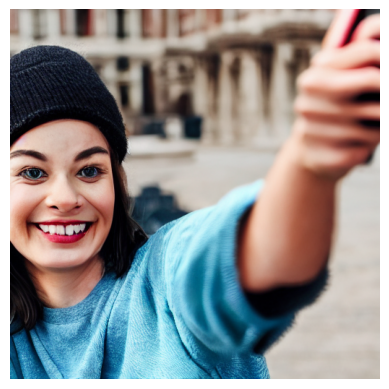

In [16]:
# Example prompt
image_prompt = "person talking a selfie" #giving prompt to generate original image
original_image = generate_image(image_prompt) # generate image with propt

# Save and display the generated image
cv2.imwrite(input_file, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))
plt.imshow(original_image)
plt.axis('off')
plt.show()


# **Initilizing the deeplabv3_resnet50**
for masking of foreground object

In [8]:
#loading model deeplabv3 to generate the mask
def load_mask_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True) # loading the deeplabv3 model
    model.eval() #setting it to evaluate mode because we are not training that modle now
    return model

#function to generate masked image
def remove_background(model, input_file):
    input_image = Image.open(input_file)#fetching the original image
    preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])#setting up the preprocess parameters

    input_tensor = preprocess(input_image) # passing original image to preprocess for normalization
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  # generating the mask
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
    mask = output_predictions.byte().cpu().numpy()
    background = np.zeros(mask.shape)
    bin_mask = np.where(mask, 255, background).astype(np.uint8)

    return bin_mask

generating the mask and for orginal generated image


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


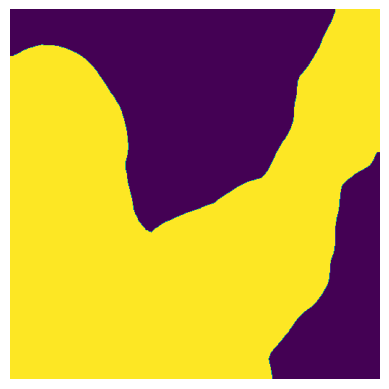

In [21]:
deeplab_model = load_mask_model()#initilizing the moel for masking
#generate the image_mask
bin_mask = remove_background(deeplab_model, input_file)#input_file is the original image generated
#save the mask
cv2.imwrite(foreground_file, cv2.cvtColor(np.array(bin_mask), cv2.COLOR_RGB2BGR))
#show the mask
plt.imshow(bin_mask)
plt.axis('off')
plt.show()

# **initilizing the stable diffusion inpainting model**

>to generate the object in masked region

In [10]:
# Step 1: Load the Stable Diffusion Inpainting Model
model_id = "runwayml/stable-diffusion-inpainting"
mask_pipeline = StableDiffusionInpaintPipeline.from_pretrained(model_id)#initilizing the model for masked image generation
mask_pipeline = mask_pipeline.to('cuda')#passong model to gpu


# Function to display images
def show_images(original, mask, result):
   # setup the subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # display the original image
    axes[0].imshow(original)
    axes[0].set_title("Originally generated Image")
    axes[0].axis("off")
    # display the mask
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Generated Mask")
    axes[1].axis("off")
    # display the result
    axes[2].imshow(result)
    axes[2].set_title("generated object replacement")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Step 2: Define the image and the prompt
original_image_path = input_file  # Replace with your image path
original_image = Image.open(original_image_path).convert("RGB") # fetching the original image



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# **generating new image by Replacing the masked object with another object**

  0%|          | 0/50 [00:00<?, ?it/s]

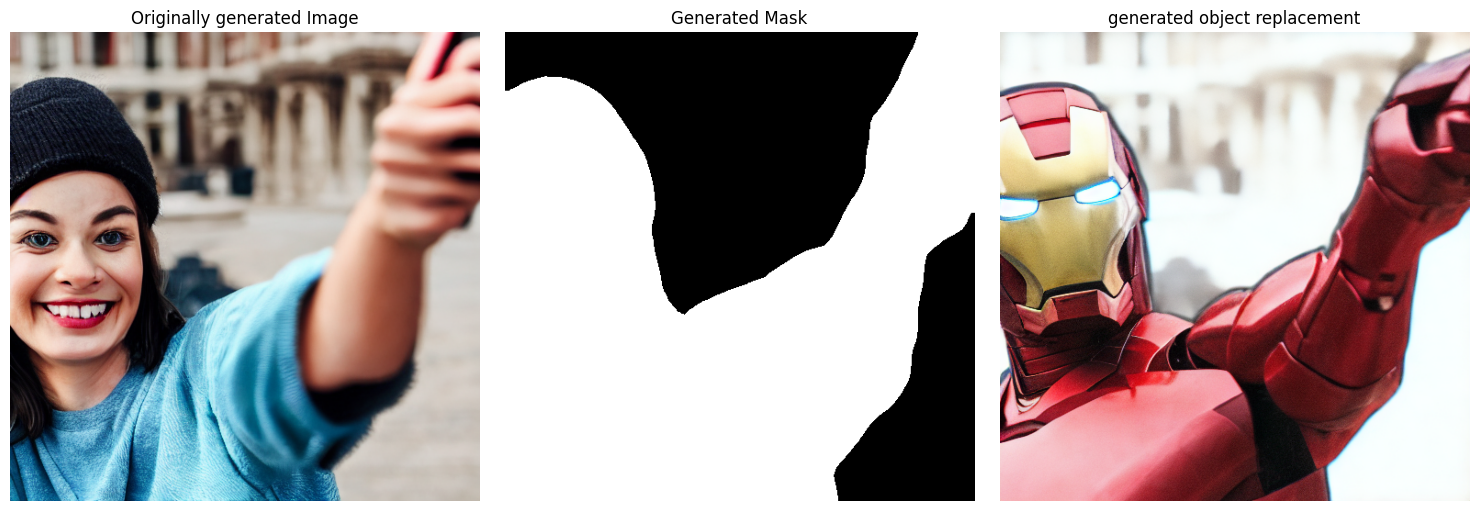

In [19]:
#prompt to generate the masked region
replacement_prompt = "ironman taking a selfie"

# Step 4: Replace the Object
#passing the original_image and image_mask with prompt to model pipeline to genrate new image
result = mask_pipeline(
    prompt=replacement_prompt,
    image=original_image,
    mask_image=bin_mask
).images[0]

# Step 5: Display the Results
show_images(original_image,bin_mask, result)

storing the result and mask


In [20]:
# saving the newgenerated image
cv2.imwrite(output_file, cv2.cvtColor(np.array(result), cv2.COLOR_RGB2BGR))


True